## Task 2 : Reconstructing using Random Fourier Features (RFF) [3 marks]

In [ ]:
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')
#import modules
import torch
from torchvision.io import read_image
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

### 1) Image Reconstruction
Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates (X,Y) to the pixel colors (R,G,B). Here, (X,Y) represents the coordinates of the pixels, and (R,G,B) represents the color values at those coordinates. Display both the original image and the reconstructed image. Also, calculate and report the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images. *[1.5 Mark]*

In [ ]:
# utility functions
def show_one_img(img: torch.Tensor):
    """Show one image."""
    plt.imshow(img)
    plt.axis('off')
    plt.show()

> Loading and reshaping image

The order of the tensor from `read_image` is often referred to as `CHW` __(Color Channels, Height, Width)__.

There's debate on whether images should be represented as `CHW` __(color channels first)__ or `HWC` __(color channels last)__.

PyTorch generally accepts `NCHW` (channels first) as the default for many operators.

*However, PyTorch also explains that `NHWC` __(channels last)__ performs better and is considered best practice. So, we change the order to `HWC` using `permute`*

torch.Size([1365, 2048, 3])


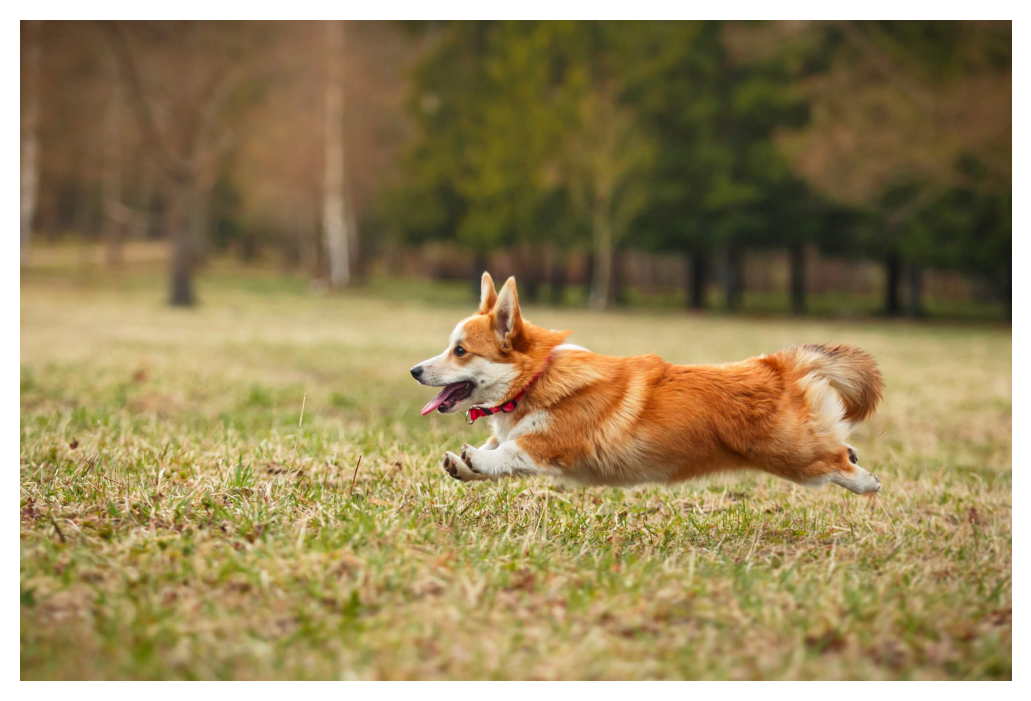

In [ ]:
filename = "dog.jpg"
img = read_image(filename).permute(1, 2, 0)
print(img.shape)
show_one_img(img)

> Scaling pixel values to between 0 and 1

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaled_img_numpy = scaler.fit_transform(img.reshape(-1, 1)).reshape(img.shape)
scaled_img = torch.Tensor(scaled_img_numpy)
scaled_img[0, 0:5, :]                   # seeing some values

tensor([[0.3098, 0.2039, 0.1373],
        [0.3137, 0.2078, 0.1412],
        [0.3137, 0.2078, 0.1412],
        [0.3176, 0.2118, 0.1451],
        [0.3216, 0.2157, 0.1490]])

> cropping the image to get a smaller section of `300 x 300 pixels`

torch.Size([300, 300, 3])


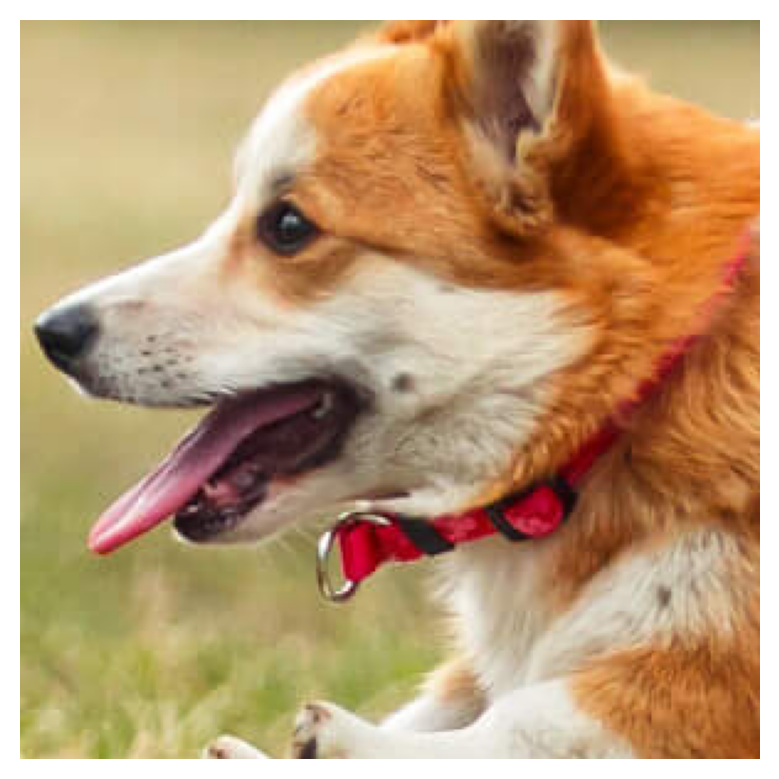

In [ ]:
cropped_img = transforms.functional.crop(scaled_img.permute(2, 0, 1), 600, 800, 300, 300).permute(1, 2, 0)    # since crop takes tensor in CHW format, we permute
print(cropped_img.shape)
show_one_img(cropped_img)

In [ ]:
#moving tensor to gpu
cropped_img = cropped_img.to(device)

> function to create a coordinate mapping for the image

In [ ]:
def create_coordinate_map(img: torch.Tensor)-> tuple[torch.Tensor, torch.Tensor]:
    """
    img shape: (height, width, num_channels)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    height, width, _ = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([w_coords, h_coords], dim=1)
    return X

coords = create_coordinate_map(cropped_img)
coords

tensor([[  0,   0],
        [  1,   0],
        [  2,   0],
        ...,
        [297, 299],
        [298, 299],
        [299, 299]])

### *References*
- [Zero to Mastery Learn PyTorch](https://www.learnpytorch.io/)
- Video - [PyTorch for Deep Learning & Machine Learning](https://www.youtube.com/watch?v=V_xro1bcAuA)
- [Radial Basis Function Kernel](https://www.geeksforgeeks.org/radial-basis-function-kernel-machine-learning/)
- [TorchVision Object Detection Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#torchvision-object-detection-finetuning-tutorial)
- [scikit-learn docs](https://scikit-learn.org/stable/api/index.html)